In [2]:
import pandas as pd

In [3]:
AMES_HOUSING_CSV = "https://www.openml.org/data/get_csv/20649135/file2ed11cebe25.arff"
df = pd.read_csv(AMES_HOUSING_CSV)
df

MS_SubClass                 MS_Zoning  \
0     One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
1     One_Story_1946_and_Newer_All_Styles  Residential_High_Density   
2     One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
3     One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
4                Two_Story_1946_and_Newer   Residential_Low_Density   
...                                   ...                       ...   
2925                  Split_or_Multilevel   Residential_Low_Density   
2926  One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
2927                          Split_Foyer   Residential_Low_Density   
2928  One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
2929             Two_Story_1946_and_Newer   Residential_Low_Density   

      Lot_Frontage  Lot_Area Street            Alley           Lot_Shape  \
0              141     31770   Pave  No_Alley_Access  Slightly_Irregular   
1               80     11622   Pave  No_Alley_Access             Regular   
2               81     14267   Pave  No_Alley_Access  Slightly_Irregular   
3               93     11160   Pave  No_Alley_Access             Regular   
4               74     13830   Pave  No_Alley_Access  Slightly_Irregular   
...            ...       ...    ...              ...                 ...   
2925            37      7937   Pave  No_Alley_Access  Slightly_Irregular   
2926             0      8885   Pave  No_Alley_Access  Slightly_Irregular   
2927            62     10441   Pave  No_Alley_Access             Regular   
2928            77     10010   Pave  No_Alley_Access             Regular   
2929            74      9627   Pave  No_Alley_Access             Regular   

     Land_Contour Utilities Lot_Config  ...            Fence Misc_Feature  \
0             Lvl    AllPub     Corner  ...         No_Fence         None   
1             Lvl    AllPub     Inside  ...  Minimum_Privacy         None   
2             Lvl    AllPub     Corner  ...         No_Fence         Gar2   
3             Lvl    AllPub     Corner  ...         No_Fence         None   
4             Lvl    AllPub     Inside  ...  Minimum_Privacy         None   
...           ...       ...        ...  ...              ...          ...   
2925          Lvl    AllPub    CulDSac  ...     Good_Privacy         None   
2926          Low    AllPub     Inside  ...  Minimum_Privacy         None   
2927          Lvl    AllPub     Inside  ...  Minimum_Privacy         Shed   
2928          Lvl    AllPub     Inside  ...         No_Fence         None   
2929          Lvl    AllPub     Inside  ...         No_Fence         None   

     Misc_Val Mo_Sold Year_Sold Sale_Type Sale_Condition Sale_Price  \
0           0       5      2010       WD          Normal     215000   
1           0       6      2010       WD          Normal     105000   
2       12500       6      2010       WD          Normal     172000   
3           0       4      2010       WD          Normal     244000   
4           0       3      2010       WD          Normal     189900   
...       ...     ...       ...       ...            ...        ...   
2925        0       3      2006       WD          Normal     142500   
2926        0       6      2006       WD          Normal     131000   
2927      700       7      2006       WD          Normal     132000   
2928        0       4      2006       WD          Normal     170000   
2929        0      11      2006       WD          Normal     188000   

      Longitude   Latitude  
0    -93.619754  42.054035  
1    -93.619756  42.053014  
2    -93.619387  42.052659  
3    -93.617320  42.051245  
4    -93.638933  42.060899  
...         ...        ...  
2925 -93.604776  41.988964  
2926 -93.602680  41.988314  
2927 -93.606847  41.986510  
2928 -93.600190  41.990921  
2929 -93.599996  41.989265  

[2930 rows x 81 columns]

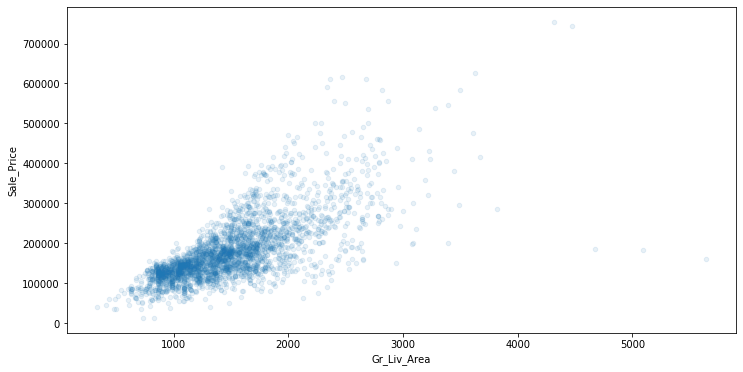

In [4]:
df.plot(x="Gr_Liv_Area", y="Sale_Price", kind="scatter",
        figsize=(12, 6), alpha=0.1);

In [5]:
import numpy as np


rng = np.random.RandomState(0)
subsample_idx = rng.choice(np.arange(len(df)), size=500, replace=False)

In [6]:
import folium
from folium.plugins import MarkerCluster


center = df[["Latitude", "Longitude"]].mean().values.tolist()
m = folium.Map(location=center, zoom_start=13)
c = MarkerCluster(options={"maxClusterRadius": 40}).add_to(m)

def make_tooltip(record):
    tooltip = f'<ul><li>$Sale_Price: {record["Sale_Price"] / 1e3:.1f}k</li>'
    tooltip += f'<li>Gr_Liv_Area: {record["Gr_Liv_Area"]:.1f}</li>'
    tooltip += f'<li>Year_Built: {record["Year_Built"]:d}</li></ul>'
    return tooltip

for i, record in df.iterrows():
    marker = folium.Marker((record["Latitude"], record["Longitude"]),
                           tooltip=make_tooltip(record))
    marker.add_to(c)

m

In [7]:
from sklearn.model_selection import train_test_split


X = df.drop(columns=["Sale_Price"])
y = df["Sale_Price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=500, random_state=0)

In [8]:
X_train.shape

(2430, 80)

In [9]:
def caterogical_columns(df):
    return df.columns[df.dtypes == object]

len(caterogical_columns(df))

46

In [10]:
def numeric_columns(df):
    return df.columns[df.dtypes != object]


len(numeric_columns(df))

35

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor


categories = [df[c].unique() for c in caterogical_columns(df)]
ord_encoder =  OrdinalEncoder(categories=categories)

preprocessor = ColumnTransformer([
    ("categorical", ord_encoder, caterogical_columns),
    ("numeric", "passthrough", numeric_columns),
])

hgb = HistGradientBoostingRegressor(
    max_leaf_nodes=3,
    learning_rate=0.5,
    early_stopping=True,
    n_iter_no_change=10,
    max_bins=5,
    max_iter=1000,
    random_state=0,
)

model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", hgb),
])

In [12]:
from sklearn.model_selection import cross_val_score


scoring = "r2"
cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                            scoring=scoring, n_jobs=2)
print(f"{scoring}: {cv_scores.mean():.3f} +/- {cv_scores.std():.3f}")

r2: 0.872 +/- 0.016


In [13]:
%%time
_ = model.fit(X_train, y_train)

CPU times: user 744 ms, sys: 2.29 ms, total: 746 ms
Wall time: 293 ms


In [14]:
r2_score_train = model.score(X_train, y_train)
print(f"r2 score (train): {r2_score_train:.3f}")

r2 score (train): 0.926


In [15]:
test_r2_score = model.score(X_test, y_test)
print(f"r2 score (test): {test_r2_score:.3f}")

r2 score (test): 0.897


In [16]:
model[-1].n_iter_

129

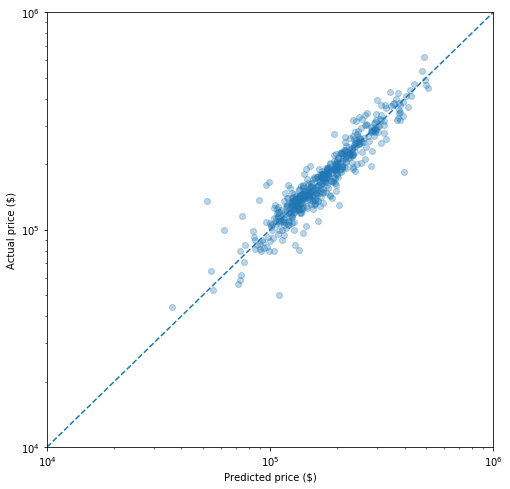

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(model.predict(X_test), y_test, alpha=0.3)
ax.plot([1e4, 1e6], [1e4, 1e6], linestyle="--")
ax.set_xlim(1e4, 1e6)
ax.set_ylim(1e4, 1e6)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Predicted price ($)")
ax.set_ylabel("Actual price ($)");

In [18]:
def mean_absolute_percent_error(y_true, y_pred):
    diffs = np.abs(y_true - y_pred)
    scales = np.abs(y_true) + np.finfo(np.float64).eps
    return np.mean(diffs / scales) * 100


y_pred = model.predict(X_test)
mape = mean_absolute_percent_error(y_test, y_pred)
print(f"MAPE: {mape:.1f}%")

MAPE: 9.7%


In [19]:
from sklearn.inspection import permutation_importance


pi = permutation_importance(model, X_test, y_test, n_repeats=5,
                            random_state=42, n_jobs=2)

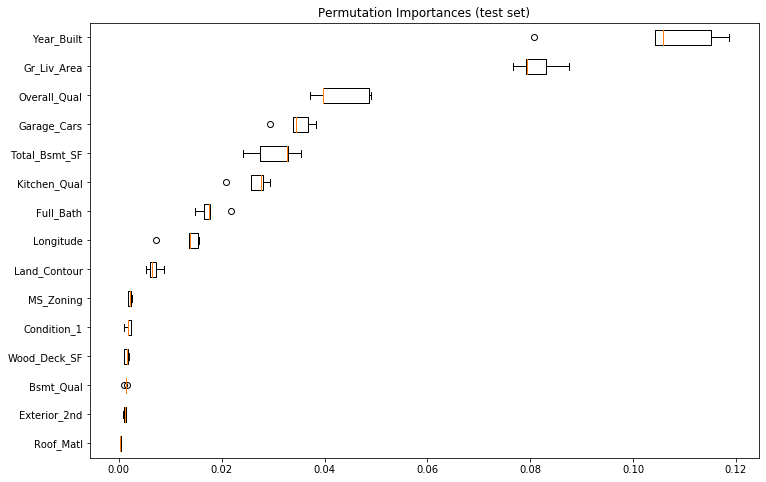

In [20]:
sorted_idx = pi.importances_mean.argsort()
most_important_idx = [
    i for i in sorted_idx
    if pi.importances_mean[i] - 4 * pi.importances_std[i] > 0
]
most_important_names = df.columns[most_important_idx]
fig, ax = plt.subplots(figsize=(12, 8))
ax.boxplot(pi.importances[most_important_idx].T,
           vert=False, labels=most_important_names)
ax.set_title("Permutation Importances (test set)");

In [21]:
feature_subset = most_important_names.tolist()
if "Latitude" not in feature_subset:
    feature_subset += ["Latitude"]
if "Longitude" not in feature_subset:
    feature_subset += ["Longitude"]

In [22]:
len(numeric_columns(df[feature_subset]))

8

In [23]:
len(caterogical_columns(df[feature_subset]))

8

In [24]:
X_train[feature_subset]

Roof_Matl Exterior_2nd Bsmt_Qual  Wood_Deck_SF Condition_1  \
483    CompShg      VinylSd      Good           224        Norm   
2585   CompShg      Wd Sdng   Typical             0        Norm   
2288   CompShg      CmentBd   Typical             0        Norm   
141    CompShg      BrkFace   Typical             0        Norm   
2041   CompShg      Wd Sdng   Typical             0       Feedr   
...        ...          ...       ...           ...         ...   
763    CompShg      Plywood      Good           120        Norm   
835    CompShg      VinylSd      Good           168        Norm   
1653   CompShg      HdBoard   Typical             0        Norm   
2607   CompShg      VinylSd   Typical             0        Norm   
2732   CompShg      MetalSd   Typical           237        Norm   

                       MS_Zoning Land_Contour  Longitude  Full_Bath  \
483      Residential_Low_Density          Lvl -93.642813          2   
2585     Residential_Low_Density          Lvl -93.617069          1   
2288  Residential_Medium_Density          Lvl -93.601507          1   
141      Residential_Low_Density          Lvl -93.617704          1   
2041  Residential_Medium_Density          Bnk -93.622025          1   
...                          ...          ...        ...        ...   
763      Residential_Low_Density          Lvl -93.658173          3   
835      Residential_Low_Density          Low -93.691883          1   
1653     Residential_Low_Density          Lvl -93.638554          2   
2607     Residential_Low_Density          Lvl -93.608984          1   
2732     Residential_Low_Density          Lvl -93.666035          1   

     Kitchen_Qual  Total_Bsmt_SF  Garage_Cars   Overall_Qual  Gr_Liv_Area  \
483          Good            952            2           Good         2256   
2585         Good            216            2  Above_Average         1575   
2288      Typical            546            1  Below_Average         1092   
141          Good           1398            2        Average         1700   
2041      Typical            925            1           Good         1889   
...           ...            ...          ...            ...          ...   
763       Typical           1200            0        Average         1200   
835          Good           1040            2        Average         1040   
1653      Typical            539            2           Good         1725   
2607      Typical           1024            2        Average         1086   
2732      Typical            967            2  Below_Average         1350   

      Year_Built   Latitude  
483         2000  42.058590  
2585        1951  42.038357  
2288        1970  41.991709  
141         1959  42.043084  
2041        1910  42.025893  
...          ...        ...  
763         1987  42.028098  
835         1996  42.021171  
1653        1979  42.052353  
2607        1966  42.040811  
2732        1954  42.026530  

[2430 rows x 16 columns]

In [25]:
%%time

categories = [df[c].unique()
              for c in caterogical_columns(df[feature_subset])]
ord_encoder =  OrdinalEncoder(categories=categories)

preprocessor = ColumnTransformer([
    ("categorical", ord_encoder, caterogical_columns),
    ("numeric", "passthrough", numeric_columns),
])
hgb = HistGradientBoostingRegressor(
    max_leaf_nodes=16,
    learning_rate=0.1,
    min_samples_leaf=5,
    early_stopping=True,
    n_iter_no_change=5,
    max_iter=1000,
    random_state=0,
)
reduced_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", hgb),
])

_= reduced_model.fit(X_train[feature_subset], y_train)

CPU times: user 1.47 s, sys: 43.9 ms, total: 1.51 s
Wall time: 470 ms


In [26]:
from sklearn.model_selection import cross_val_score


scoring = "r2"
cv_scores = cross_val_score(reduced_model, X_train[feature_subset], y_train, cv=5,
                            scoring=scoring, n_jobs=2)
print(f"{scoring}: {cv_scores.mean():.3f} +/- {cv_scores.std():.3f}")

r2: 0.880 +/- 0.019


In [27]:
%%time
_ = reduced_model.fit(X_train[feature_subset], y_train)

CPU times: user 1.09 s, sys: 11.3 ms, total: 1.1 s
Wall time: 360 ms


In [28]:
r2_score_train = reduced_model.score(X_train[feature_subset], y_train)
print(f"r2 score (train): {r2_score_train:.3f}")

r2 score (train): 0.949


In [29]:
test_r2_score = reduced_model.score(X_test[feature_subset], y_test)
print(f"r2 score (test): {test_r2_score:.3f}")

r2 score (test): 0.903


In [30]:
reduced_model[-1].n_iter_

80

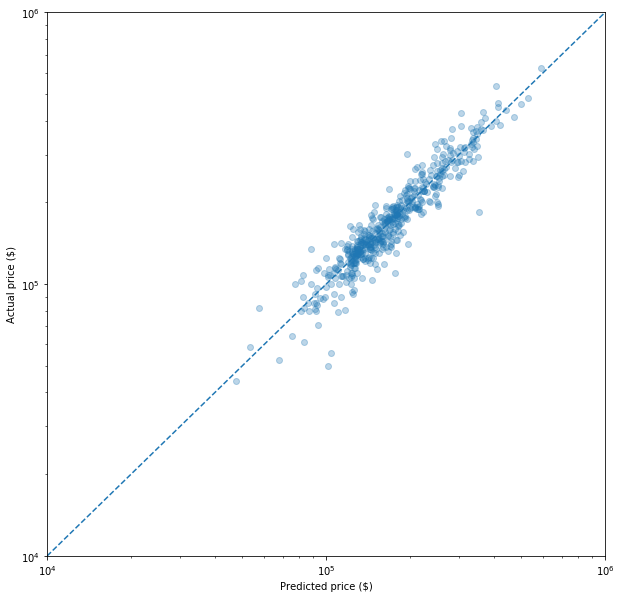

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(reduced_model.predict(X_test[feature_subset]), y_test, alpha=0.3)
ax.plot([1e4, 1e6], [1e4, 1e6], linestyle="--")
ax.set_xlim(1e4, 1e6)
ax.set_ylim(1e4, 1e6)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Predicted price ($)")
ax.set_ylabel("Actual price ($)");

In [32]:
y_pred = reduced_model.predict(X_test[feature_subset])
mape = mean_absolute_percent_error(y_test, y_pred)
print(f"MAPE: {mape:.1f}%")

MAPE: 10.0%


In [33]:
y_pred = model.predict(X_test)
mape = mean_absolute_percent_error(y_test, y_pred)
print(f"MAPE: {mape:.1f}%")

MAPE: 9.7%


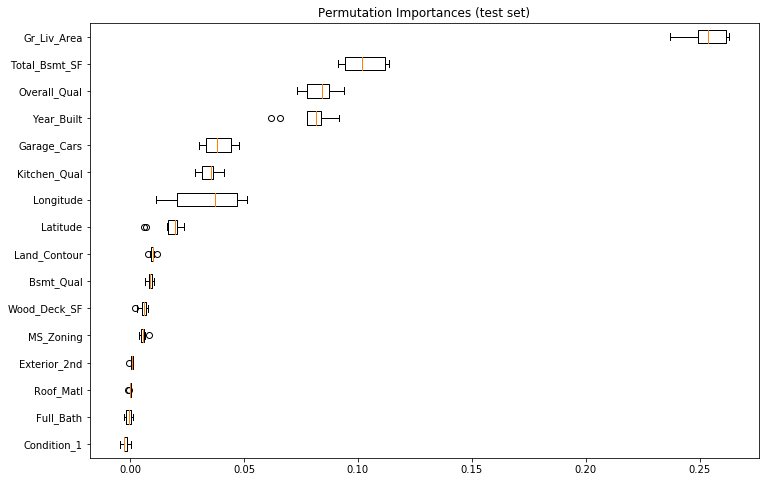

In [34]:
from sklearn.inspection import permutation_importance


pi = permutation_importance(reduced_model, X_test[feature_subset], y_test, n_repeats=10,
                            random_state=42, n_jobs=2)

sorted_idx = pi.importances_mean.argsort()
sorted_names = np.array(feature_subset)[sorted_idx]
fig, ax = plt.subplots(figsize=(12, 8))
ax.boxplot(pi.importances[sorted_idx].T,
           vert=False, labels=sorted_names)
ax.set_title("Permutation Importances (test set)");

In [35]:
# %pip install -q git+https://github.com/slundberg/shap

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


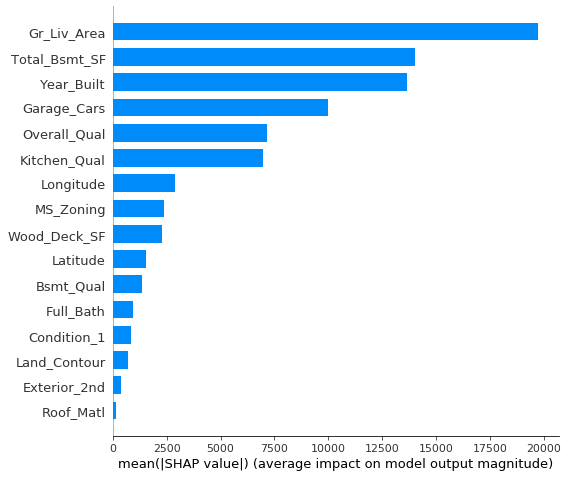

In [44]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(reduced_model[-1])
X_test_encoded = reduced_model[0].transform(X_test[feature_subset])
shap_values = explainer.shap_values(X_test_encoded)
feature_names = caterogical_columns(X_test[feature_subset]).tolist()
feature_names += numeric_columns(X_test[feature_subset]).tolist()
X_test_encoded = pd.DataFrame(X_test_encoded, columns=feature_names)
shap.summary_plot(shap_values, X_test_encoded, plot_type="bar")

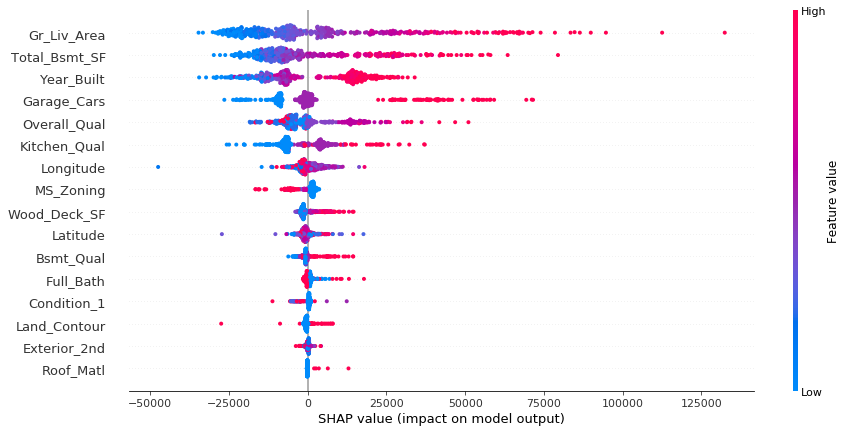

In [45]:
shap.summary_plot(shap_values, X_test_encoded, plot_size=(14, 7))

In [46]:
sample_idx = 0
print("True sale price:", y_test.iloc[sample_idx])
shap.force_plot(explainer.expected_value, shap_values[sample_idx, :],
                X_test_encoded.iloc[sample_idx, :])

True sale price: 220000


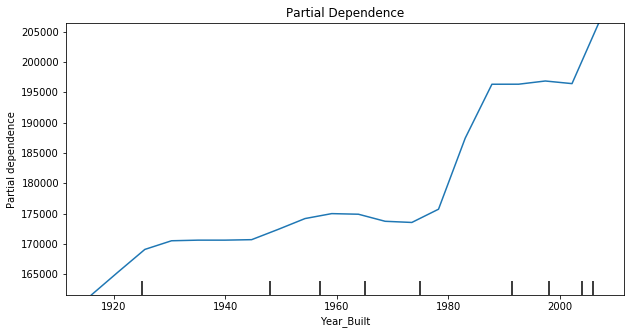

In [47]:
from sklearn.inspection import plot_partial_dependence

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Partial Dependence")
plot_partial_dependence(reduced_model, X_test[feature_subset],
                        ["Year_Built"], grid_resolution=20, ax=ax);

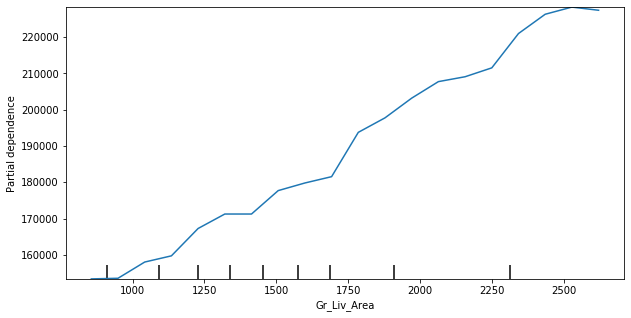

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_partial_dependence(reduced_model, X_test[feature_subset], ["Gr_Liv_Area"],
                        grid_resolution=20, ax=ax);

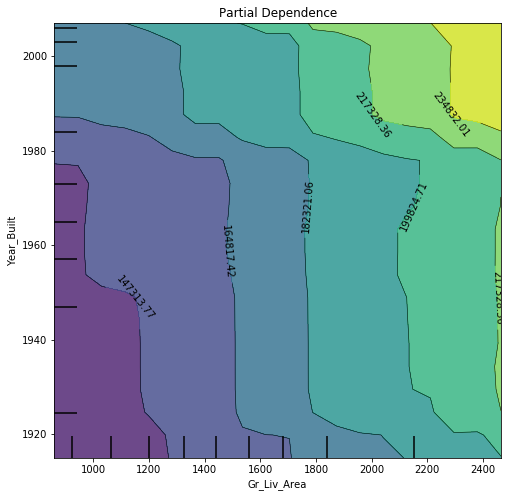

In [49]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Partial Dependence")
plot_partial_dependence(reduced_model, X[feature_subset], [["Gr_Liv_Area", "Year_Built"]],
                        grid_resolution=20, contour_kw={"alpha": 0.8}, ax=ax);

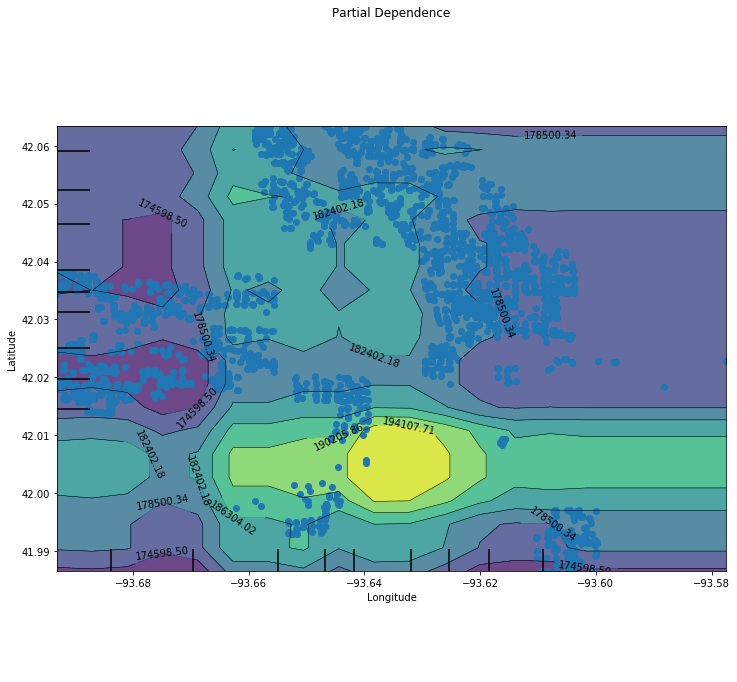

In [50]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title("Partial Dependence")
plot_partial_dependence(reduced_model, X[feature_subset],
                        [["Longitude", "Latitude"]],
                        percentiles=(0., 1.),
                        grid_resolution=20, contour_kw={"alpha": 0.8}, ax=ax)
ax = fig.gca()
ax.set_xlim(X["Longitude"].min(), X["Longitude"].max())
ax.set_ylim(X["Latitude"].min(), X["Latitude"].max())
ax.set_aspect("equal")
ax.scatter(X["Longitude"], X["Latitude"]);

In [51]:
HistGradientBoostingRegressor()

HistGradientBoostingRegressor(early_stopping='auto', l2_regularization=0.0,
                              learning_rate=0.1, loss='least_squares',
                              max_bins=255, max_depth=None, max_iter=100,
                              max_leaf_nodes=31, min_samples_leaf=20,
                              n_iter_no_change=10, random_state=None,
                              scoring='loss', tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)

In [52]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

categories = [df[c].unique()
              for c in caterogical_columns(df)]
ord_encoder =  OrdinalEncoder(categories=categories)

preprocessor = ColumnTransformer([
    ("categorical", ord_encoder, caterogical_columns),
    ("numeric", "passthrough", numeric_columns),
])
hgb = HistGradientBoostingRegressor(
    early_stopping=True,
    n_iter_no_change=10,
    max_iter=1000,
)
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", hgb),
])


params = {
    "regressor__learning_rate": np.logspace(-3, 0, 10),
    "regressor__max_leaf_nodes": [2, 3, 4, 5, 6, 8, 16, 32, 64],
    "regressor__max_bins": [3, 5, 10, 30, 50, 100, 255],
    "regressor__min_samples_leaf": [1, 2, 5, 10, 20, 50, 100],
}
search = RandomizedSearchCV(model, params, n_iter=200, cv=3,
                            n_jobs=4, verbose=1)

In [53]:
# _ = search.fit(X_train, y_train)

In [54]:
# cv_results = pd.DataFrame(search.cv_results_)
# cv_results = cv_results.sort_values("mean_test_score", ascending=False)
# cv_results.to_json("ames_gbrt_search_results.json")

In [55]:
cv_results = pd.read_json("ames_gbrt_search_results.json")

In [56]:
cv_results.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
41        1.150603      0.125701         0.047464        0.016420   
71        1.278917      0.243353         0.052712        0.020205   
75        0.658366      0.108563         0.053916        0.023610   
168       0.761223      0.226863         0.048083        0.013343   
78        0.767932      0.128119         0.034624        0.003252   
166       6.969258      1.634544         0.087485        0.023078   
15        7.902748      1.662107         0.099497        0.017213   
169       1.037296      0.511847         0.039779        0.005016   
85        3.906909      1.043321         0.045697        0.006138   
92        0.427495      0.020798         0.032705        0.001098   

     param_regressor__min_samples_leaf  param_regressor__max_leaf_nodes  \
41                                  10                               16   
71                                   2                               16   
75                                   5                               16   
168                                 10                                8   
78                                   5                               16   
166                                  2                               16   
15                                  20                               32   
169                                  5                                8   
85                                  10                               32   
92                                  10                                8   

     param_regressor__max_bins  param_regressor__learning_rate  \
41                         255                        0.046416   
71                         255                        0.100000   
75                          10                        0.100000   
168                         30                        0.046416   
78                         255                        0.100000   
166                        255                        0.010000   
15                         100                        0.010000   
169                        255                        0.046416   
85                         255                        0.021544   
92                         100                        0.100000   

                                                params  split0_test_score  \
41   {'regressor__min_samples_leaf': 10, 'regressor...           0.884028   
71   {'regressor__min_samples_leaf': 2, 'regressor_...           0.882843   
75   {'regressor__min_samples_leaf': 5, 'regressor_...           0.885774   
168  {'regressor__min_samples_leaf': 10, 'regressor...           0.887633   
78   {'regressor__min_samples_leaf': 5, 'regressor_...           0.885211   
166  {'regressor__min_samples_leaf': 2, 'regressor_...           0.875900   
15   {'regressor__min_samples_leaf': 20, 'regressor...           0.876968   
169  {'regressor__min_samples_leaf': 5, 'regressor_...           0.881061   
85   {'regressor__min_samples_leaf': 10, 'regressor...           0.873613   
92   {'regressor__min_samples_leaf': 10, 'regressor...           0.868922   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
41            0.894805           0.915227         0.898020        0.012938   
71            0.891829           0.919236         0.897969        0.015479   
75            0.892744           0.910826         0.896448        0.010558   
168           0.885017           0.916373         0.896341        0.014205   
78            0.892230           0.911465         0.896302        0.011098   
166           0.893156           0.918720         0.895926        0.017590   
15            0.891900           0.916014         0.894961        0.016087   
169           0.890307           0.911530         0.894299        0.012755   
85            0.895131           0.912551         0.893765        0.015926   
92            0.894142           0.916191         0.893085      

In [57]:
cv_results["safe_test_score"] = cv_results["mean_test_score"] - cv_results["std_test_score"]

In [58]:
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()


param_names = [c for c in cv_results.columns
               if c.startswith("param_")]
fig = px.scatter(cv_results, x="mean_score_time", y="safe_test_score",
                 hover_data=param_names)

fig.show()